## AFRICA Air Quality Archive Vanderbijlpark 

In [78]:
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

In [34]:

def wrangle(filename):
    #We read the filename into a dataframe and passing the ';' as a delimiter
    df = pd.read_csv(filename,delimiter=';')
    # We convert our timestamp column of object datatype to a timestamp datatype
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    # We set the index of the dataframe to be the timestamp 
    df.set_index('timestamp',inplace=True)
    #We  convert the timestamp to the 'Africa/Johannesburg' timezone since the dataset is gotten from Vanderbijlpark
    df.index = df.index.tz_convert('Africa/Johannesburg')
    #We mask our DataFrame to return value that contains the P2 value type
    mask = df['value_type'] == 'P2'
    df  = df[mask]
    ## we identify column with low and high cardinality and drop them
    low_cardinality_list = [column for column in df.columns if df[column].nunique() < 2 ]
    df.drop(low_cardinality_list,axis=1,inplace = True)
    # We resample the dataframe to return a series with the mean of the P2 value for every Hour
    y =  df['value'].resample('1H').mean().fillna(method ='ffill')
    y.name = 'P2'
    return y
    

### 1. IMPORT

In [35]:
#Returns all files that matches the pattern as specified in the glob function argument
files = glob('data/*_2021_sensor_data_archive.csv')

In [36]:
#A list comprehension for that perform the wrangle function for each file in the list created by glob funtion
list_of_df = [wrangle(file) for file in files]
# We concatenate the list of dataframes into one dataframe using the pd.concat method and set index to the timestamp
y = pd.concat(list_of_df)

In [37]:
y.head()

timestamp
2021-07-01 02:00:00+02:00    45.566296
2021-07-01 03:00:00+02:00    44.161481
2021-07-01 04:00:00+02:00    38.362778
2021-07-01 05:00:00+02:00    41.146667
2021-07-01 06:00:00+02:00    44.614717
Name: P2, dtype: float64

In [38]:
y.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 2989 entries, 2021-07-01 02:00:00+02:00 to 2021-09-01 01:00:00+02:00
Series name: P2
Non-Null Count  Dtype  
--------------  -----  
2989 non-null   float64
dtypes: float64(1)
memory usage: 46.7 KB


### 2. EXPLORE

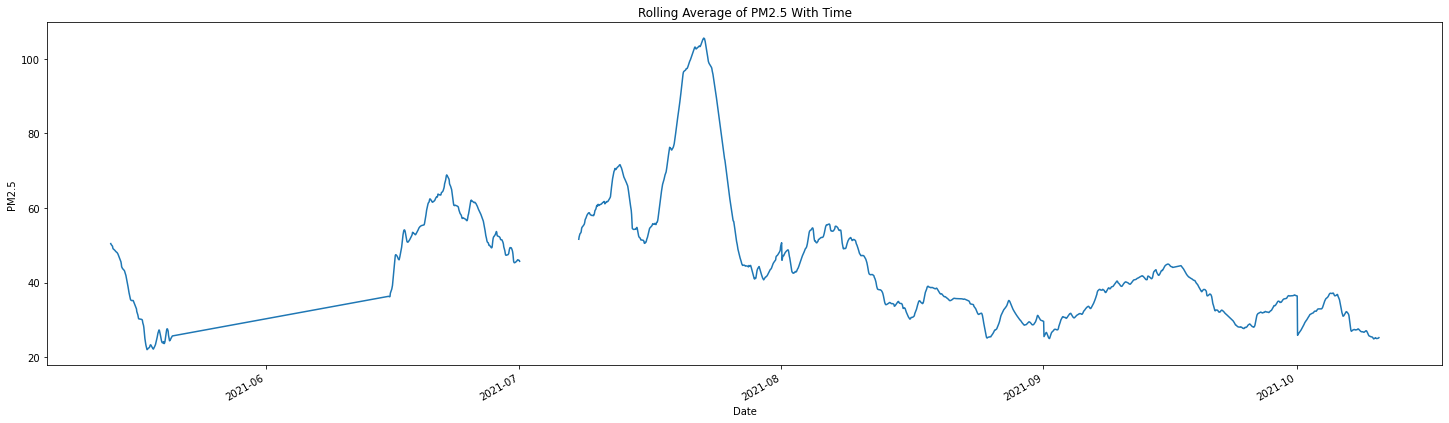

In [39]:
#We plot the weekly rolling average to get an idea of how the data could change in future
fig,ax = plt.subplots(figsize=(25,7))
y.rolling(168).mean().plot(ax=ax);
plt.xlabel('Date')
plt.ylabel('PM2.5')
plt.title('Rolling Average of PM2.5 With Time');


In [40]:
#Since we have no feature and only a target value, we could create a lag feature from the target.
#First we convert our series to a DataFrame
df = y.to_frame()
df.head()

,P2
timestamp,
2021-07-01 02:00:00+02:00,45.566296
2021-07-01 03:00:00+02:00,44.161481
2021-07-01 04:00:00+02:00,38.362778
2021-07-01 05:00:00+02:00,41.146667
2021-07-01 06:00:00+02:00,44.614717


In [45]:
# Next we create a new feature called 'P2.Lag1' which is the value from previous row
df['P2.Lag1'] = df['P2'].shift(1)
df.dropna(inplace=True)

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2988 entries, 2021-07-01 03:00:00+02:00 to 2021-09-01 01:00:00+02:00
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   P2       2988 non-null   float64
 1   P2.Lag1  2988 non-null   float64
dtypes: float64(2)
memory usage: 70.0 KB


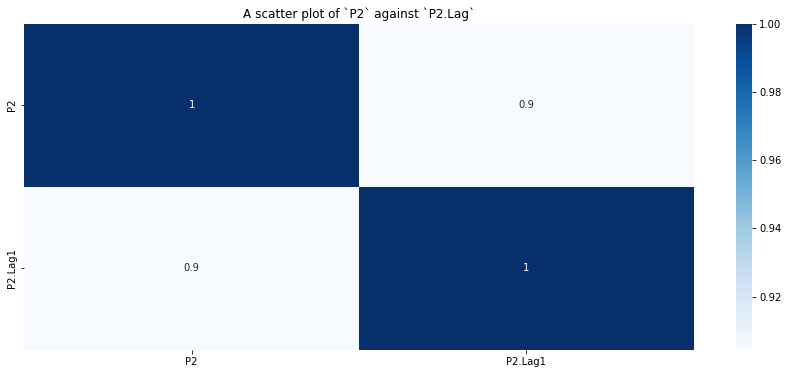

In [64]:
#Next we create a heatmap between the feature and target
fig,ax = plt.subplots(figsize=(15,6))
sns.heatmap(df.corr(),annot=True,ax=ax,cmap='Blues')
#Title
plt.title('A scatter plot of `P2` against `P2.Lag`');

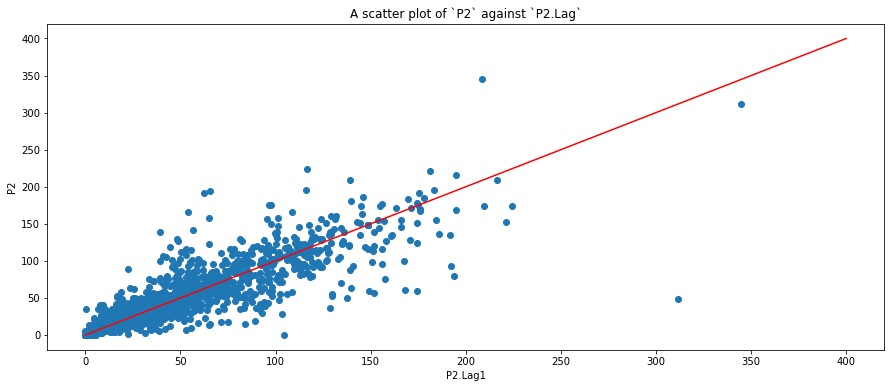

In [66]:
fig,ax = plt.subplots(figsize=(15,6))
#We plot a scatter plot of 'P2' against 'P2.Lag'
plt.scatter(data = df,x='P2.Lag1',y='P2')
#We plot a straight line from the origin to check our distributed our scatter plot.
plt.plot([0,400],[0,400],linestyle='solid',color='red')
#xlabel
plt.xlabel('P2.Lag1')
plt.ylabel('P2')
plt.title('A scatter plot of `P2` against `P2.Lag`');

### 3. SPLIT

In [69]:
# Split DataFrame in X(Feature) and y(Target).
target = 'P2'
# Feature column
X = df.drop(target,axis=1)
y = df[target]

In [72]:
#We split into Train and Test set. Since it is a Time Based Data, We ensure no future data is present in the test set.
# We Split in the Ratio 80:20
cut_off = int(len(X)*0.8)
X_train = X[:cut_off]
X_test = X[cut_off:]
y_train = y[:cut_off]
y_test = y[cut_off:]

### 4. BUILD MODEL

#### BASELINE

In [79]:
# We create a baseline model which would be used to test how well our test data those.
# The baseline will be the mean absolute error of y_train against that of y_mean
y_mean = y_train.mean()
y_pred_baseline = [y_mean]*len(y_train)
mae = mean_absolute_error(y_train,y_pred_baseline)
print(f' The mean of the y_train is {y_mean}')
print(f' The mean absolute error of the baseline model is {mae}')

 The mean of the y_train is 47.00080913216241
 The mean absolute error of the baseline model is 28.37168266149257
